# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [63]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [64]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [65]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [66]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [67]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [68]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [69]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [70]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [71]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8L, 27L)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [72]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]], dtype=int64)

In [73]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [74]:
df_wine = pd.read_csv('winequality-red.csv', sep=';')

In [75]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [76]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [77]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

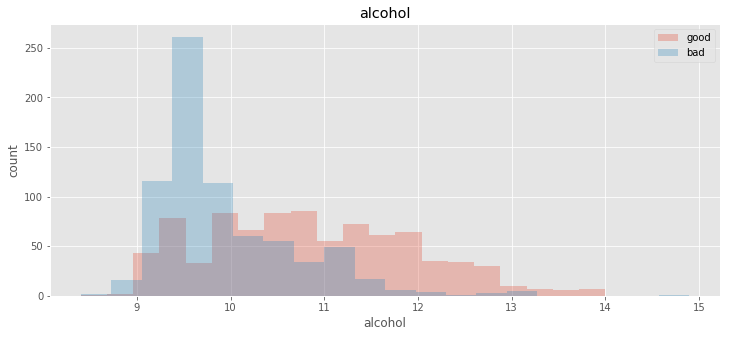

In [80]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [165]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values
X, y

(array([[  7.4  ,   0.7  ,   0.   , ...,   3.51 ,   0.56 ,   9.4  ],
        [  7.8  ,   0.88 ,   0.   , ...,   3.2  ,   0.68 ,   9.8  ],
        [  7.8  ,   0.76 ,   0.04 , ...,   3.26 ,   0.65 ,   9.8  ],
        ..., 
        [  6.3  ,   0.51 ,   0.13 , ...,   3.42 ,   0.75 ,  11.   ],
        [  5.9  ,   0.645,   0.12 , ...,   3.57 ,   0.71 ,  10.2  ],
        [  6.   ,   0.31 ,   0.47 , ...,   3.39 ,   0.66 ,  11.   ]]),
 array([0, 0, 0, ..., 1, 0, 1]))

Далее вы увидете пример реализации этого простого классификатора.

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [104]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [105]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [106]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [108]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [109]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [110]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import copy
import random
from sklearn.base import ClusterMixin
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial import distance
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=3, metric='euclidean', max_iter=1000, random_state=None, init='random',eps=0.01):
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init              
        self.centroids = np.zeros((self.k,X.shape[1]))   
        self.eps = eps
    def dist_from_centers(self, X):
        cent = self.centroids
        distance = np.array([min([np.dot(x-c,x-c)**2 for c in cent]) for x in X])
        self.distance = distance
    def chose_next(self, X):
        self.probs = self.distance/self.distance.sum()
        self.cumprobs = self.probs.cumsum()
        r = random.random()
        ind = np.where(self.cumprobs >= r)[0][0]
        return(X[ind])           
    def init_centers(self,X):
        self.centroids = random.sample(X,1)
        while len(self.centroids) < self.k:
            self.dist_from_centers(X)
            self.centroids.append(self.chose_next(X))       
        
    def fit(self, X, y=None):
        np.random.seed(self.random_state)        
        self.labels = np.empty(X.shape[0], dtype=np.int32)  
        self.centroids_prev_iteration = np.zeros((self.k, X.shape[1]))
        if self.init == 'random': 
            for i in xrange(self.k):
                self.centroids[i] = X[random.randint(0,X.shape[0] - 1)]
            
        if self.init == 'k-means':
            self.init_centers(X)        
        for iter_num in xrange(self.max_iter):           
            C = np.array(np.argmin(distance.cdist(X,self.centroids),axis=1))
            self.centroids = [X[C == k].mean(axis = 0) for k in xrange(self.k)]
            move_sum = 0            
            for i in xrange(self.k): 
                try:
                    move_sum += distance.euclidean(self.centroids[i],self.centroids_prev_iteration[i])
                except ValueError:
                    self.centroids[i] = self.centroids_prev_iteration[i]
                    continue
            move_sum /= self.k
            print 'total centroids moves:' , move_sum      
            if move_sum < self.eps:
                #print 'iter_num: ' , iter_num
                self.labels = C
                return self
            self.centroids_prev_iteration = copy.copy(self.centroids)
        self.labels = C
        return self
    
    def predict(self, X, y=None):       
        return self.labels         
        
        
class MiniBatchKMeans(Kmeans):
    def init_mini_batch(self, X, b=10):
        if self.init == 'random': 
            for i in xrange(self.k):
                self.centroids[i] = X[random.randint(0,X.shape[0] - 1)]
        if self.init == 'k-means':
            self.init_centers(X)
        self.batch_size = b 
    
    def miniBatchFit(self, X):
        np.random.seed(self.random_state)
        self.labels = np.empty(X.shape[0], dtype=np.int32)  
        self.centroids_prev_iteration = np.zeros((self.k, X.shape[1]))
        v = np.zeros(self.k)
        eps = 0.01        
        for iter_num in xrange(self.max_iter):            
            mini_batch = random.sample(X,self.batch_size) 
            D = np.array(np.argmin(distance.cdist(X,self.centroids),axis=1))

            #D = np.array([np.argmin([np.dot(x_i-y_k, x_i-y_k) for y_k in self.centroids]) for x_i in mini_batch])            
            for i in xrange(len(mini_batch)):          
                index = D[i]               
                v[index] +=1                
                eta = 1 / v[index]
                self.centroids[index] = (1 - eta) * self.centroids[index] + eta * mini_batch[i]                
            move_sum = 0
            for i in xrange(self.k): 
                try:
                    move_sum += distance.euclidean(self.centroids[i],self.centroids_prev_iteration[i])
                except ValueError:
                    self.centroids[i] = self.centroids_prev_iteration[i]
                    continue
            move_sum /= self.k    
            if move_sum < self.eps:
                #print 'iter_num: ', iter_num
                self.labels = np.array([np.argmin([np.dot(x_i-y_k, x_i-y_k) for y_k in self.centroids]) for x_i in X]) 
                return self
            self.centroids_prev_iteration = copy.copy(self.centroids)
        self.labels = np.array([np.argmin([np.dot(x_i-y_k, x_i-y_k) for y_k in self.centroids]) for x_i in X]) 


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [4]:
from sklearn.datasets import make_blobs
import matplotlib

In [5]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)


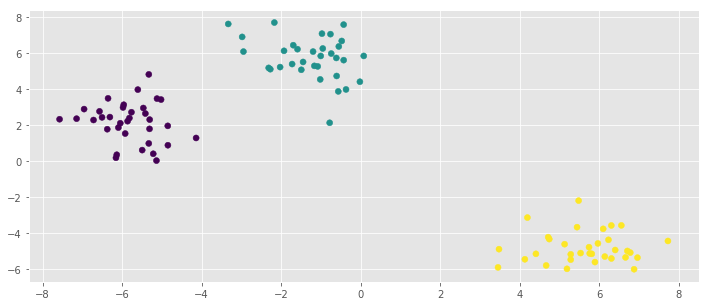

In [7]:
plt.scatter(X[:,0], X[:, 1], c=y)


Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

total centroids moves: 6.57957445939
total centroids moves: 1.0848935383
total centroids moves: 0.0857649352652
total centroids moves: 0.0


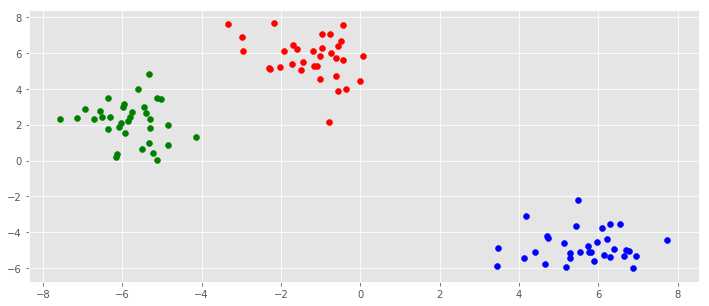

In [8]:
## Работоспособность KMeans

from sklearn.datasets import make_blobs
import matplotlib
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
model = Kmeans()
model = model.fit(X)
plt.scatter(X[model.labels==0,0],X[model.labels==0,1], c='r' )
plt.scatter(X[model.labels==1,0],X[model.labels==1,1], c='g' )
plt.scatter(X[model.labels==2,0],X[model.labels==2,1], c='b' )

total centroids moves: 6.4961482361
total centroids moves: 0.0


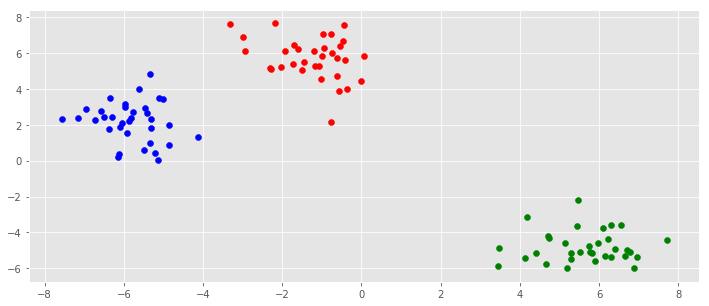

In [9]:
## Работоспособность KMeans++
from sklearn.datasets import make_blobs
import matplotlib
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
modelplus = Kmeans(init='k-means')
result = modelplus.fit(X)
plt.scatter(X[result.labels==0,0],X[result.labels==0,1], c='r' )
plt.scatter(X[result.labels==1,0],X[result.labels==1,1], c='g' )
plt.scatter(X[result.labels==2,0],X[result.labels==2,1], c='b' )

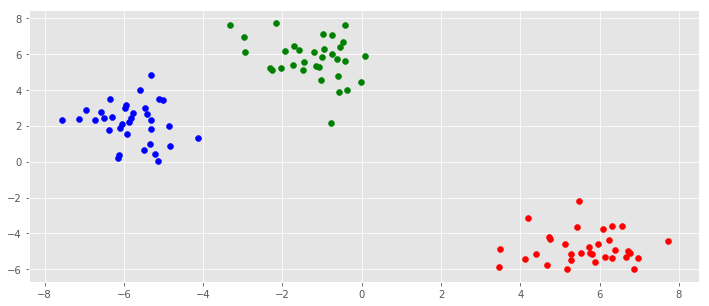

In [45]:
## Работоспособность KMeans с MiniBatchKMeans
from sklearn.datasets import make_blobs
import matplotlib
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
model_mini_batch = MiniBatchKMeans()
model_mini_batch.init_mini_batch(X,b=10)
result = model_mini_batch.miniBatchFit(X)
plt.scatter(X[result.labels==0,0],X[result.labels==0,1], c='r' )
plt.scatter(X[result.labels==1,0],X[result.labels==1,1], c='g' )
plt.scatter(X[result.labels==2,0],X[result.labels==2,1], c='b' )

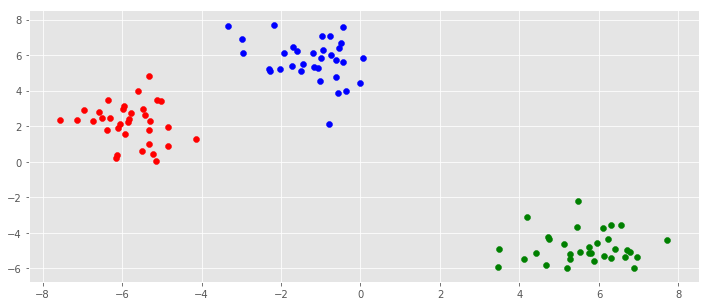

In [11]:
## Работоспособность KMeans++ с MiniBatchKMeans
from sklearn.datasets import make_blobs
import matplotlib
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
model_mini_batch = MiniBatchKMeans(init='k-means')
model_mini_batch.init_mini_batch(X,b=10)
result = model_mini_batch.miniBatchFit(X)
plt.scatter(X[result.labels==0,0],X[result.labels==0,1], c='r' )
plt.scatter(X[result.labels==1,0],X[result.labels==1,1], c='g' )
plt.scatter(X[result.labels==2,0],X[result.labels==2,1], c='b' )

total centroids moves: 6.66483830369
total centroids moves: 0.0604485036924
total centroids moves: 0.0391137199913
total centroids moves: 0.0
total centroids moves: 5.58701561208
total centroids moves: 1.56853329303
total centroids moves: 0.0
total centroids moves: 5.09406395606
total centroids moves: 2.80546670789
total centroids moves: 0.710895833047
total centroids moves: 0.0
total centroids moves: 6.49278407869
total centroids moves: 0.0690934152779
total centroids moves: 0.0
total centroids moves: 6.7958413315
total centroids moves: 0.157579691277
total centroids moves: 0.121123984534
total centroids moves: 0.0693806141299
total centroids moves: 0.122826670927
total centroids moves: 0.0391137199913
total centroids moves: 0.0
total centroids moves: 6.72003051043
total centroids moves: 0.114100196517
total centroids moves: 0.125930185221
total centroids moves: 0.0511723420878
total centroids moves: 0.0391137199913
total centroids moves: 0.0
total centroids moves: 4.57419956947
total

total centroids moves: 0.0693016175249
total centroids moves: 0.0379546879637
total centroids moves: 0.0271674923133
total centroids moves: 0.0170686900111
total centroids moves: 0.0158291026393
total centroids moves: 0.0229340103542
total centroids moves: 0.0140687608928
total centroids moves: 0.0136329534767
total centroids moves: 0.0135226678056
total centroids moves: 0.018000198439
total centroids moves: 0.0112067178183
total centroids moves: 0.00963028225555
total centroids moves: 6.68871164496
total centroids moves: 0.00941524600871
total centroids moves: 7.08942840107
total centroids moves: 0.151580343065
total centroids moves: 0.105531386273
total centroids moves: 0.0685145336702
total centroids moves: 0.0466267525608
total centroids moves: 0.0287059009297
total centroids moves: 0.020405454094
total centroids moves: 0.00958062348581
total centroids moves: 5.50155034624
total centroids moves: 2.03865570902
total centroids moves: 0.0105875661108
total centroids moves: 0.0
total c

total centroids moves: 0.885376902409
total centroids moves: 0.148771685583
total centroids moves: 0.00584751051935
total centroids moves: 6.56262695073
total centroids moves: 0.0238727807338
total centroids moves: 0.0
total centroids moves: 6.41892840984
total centroids moves: 0.773816548037
total centroids moves: 0.0932296510508
total centroids moves: 0.0029702826212
total centroids moves: 4.86414900607
total centroids moves: 2.97061185607
total centroids moves: 0.0409025260503
total centroids moves: 0.000974544871933
total centroids moves: 6.59677132426
total centroids moves: 0.0328863568493
total centroids moves: 0.0228211183485
total centroids moves: 0.0163616298079
total centroids moves: 0.0140605006133
total centroids moves: 0.0127757281112
total centroids moves: 0.0137866222787
total centroids moves: 0.018235340438
total centroids moves: 0.0157252387946
total centroids moves: 0.014434931322
total centroids moves: 0.0134218480436
total centroids moves: 0.00798369297673
total cen

total centroids moves: 0.211247827266
total centroids moves: 0.00878612762097
total centroids moves: 6.90129515327
total centroids moves: 0.098485610945
total centroids moves: 0.066901586507
total centroids moves: 0.0394813503322
total centroids moves: 0.0233411055928
total centroids moves: 0.0171183689181
total centroids moves: 0.0106972230331
total centroids moves: 0.00408440495966
total centroids moves: 6.55952049855
total centroids moves: 0.100727913233
total centroids moves: 0.0029556611113
total centroids moves: 6.66642945753
total centroids moves: 0.00891209524028
total centroids moves: 6.55950385669
total centroids moves: 0.0247207268647
total centroids moves: 0.000335595027154
total centroids moves: 6.56137066013
total centroids moves: 0.0110897991324
total centroids moves: 0.0
total centroids moves: 6.56070857934
total centroids moves: 0.00320241872069
total centroids moves: 6.9490624235
total centroids moves: 0.118704869522
total centroids moves: 0.0813425406157
total centro

total centroids moves: 0.00992368294306
total centroids moves: 6.562933435
total centroids moves: 0.00187385945768
total centroids moves: 6.56309721066
total centroids moves: 0.0676534780213
total centroids moves: 0.00187032664029
total centroids moves: 4.51210816835
total centroids moves: 2.56420719717
total centroids moves: 2.09494483695
total centroids moves: 0.259156208581
total centroids moves: 0.00614630055937
total centroids moves: 6.45455805741
total centroids moves: 1.19433045845
total centroids moves: 0.0576630070242
total centroids moves: 0.00179360922217
total centroids moves: 6.55401181672
total centroids moves: 0.0347893188449
total centroids moves: 0.000509524955882
total centroids moves: 6.56181955525
total centroids moves: 0.0272628898303
total centroids moves: 0.00102672949576
total centroids moves: 6.56182545122
total centroids moves: 0.0249903480476
total centroids moves: 0.00102672949576
total centroids moves: 6.5615086605
total centroids moves: 0.00998403061822
to

total centroids moves: 0.0441028647547
total centroids moves: 0.0274346726979
total centroids moves: 0.0179350011166
total centroids moves: 0.0116934750373
total centroids moves: 0.00640556012985
total centroids moves: 6.56192481411
total centroids moves: 0.0674567141823
total centroids moves: 0.0014717514596
total centroids moves: 6.3028569955
total centroids moves: 1.25908811877
total centroids moves: 0.0380641848236
total centroids moves: 0.000498386697679
total centroids moves: 6.56028627818
total centroids moves: 0.0155119900145
total centroids moves: 0.000337881992782
total centroids moves: 6.56001159618
total centroids moves: 0.147348186881
total centroids moves: 0.00522613040845
total centroids moves: 3.6462940169
total centroids moves: 2.85098215551
total centroids moves: 1.34312665808
total centroids moves: 0.656991575534
total centroids moves: 0.0481441184764
total centroids moves: 0.000829400769299
total centroids moves: 5.5424484998
total centroids moves: 1.82540925144
tot

total centroids moves: 6.56043399561
total centroids moves: 0.0204653435558
total centroids moves: 0.000728014511285
total centroids moves: 6.56448350409
total centroids moves: 0.00638084777324
total centroids moves: 6.83878763905
total centroids moves: 0.0748048616663
total centroids moves: 0.0452259360896
total centroids moves: 0.028312146288
total centroids moves: 0.017574929243
total centroids moves: 0.0129744513386
total centroids moves: 0.0109214247768
total centroids moves: 0.00983945642027
total centroids moves: 6.95892925579
total centroids moves: 0.123351692986
total centroids moves: 0.0732089271007
total centroids moves: 0.0452253463969
total centroids moves: 0.029257283717
total centroids moves: 0.018275323134
total centroids moves: 0.0131513260128
total centroids moves: 0.00955954260518
total centroids moves: 6.48238085141
total centroids moves: 0.134873696579
total centroids moves: 0.0840763185706
total centroids moves: 0.0514671198936
total centroids moves: 0.03407392046

total centroids moves: 6.73298979523
total centroids moves: 0.0871949602889
total centroids moves: 0.0545602255429
total centroids moves: 0.0376118224475
total centroids moves: 0.0245415037134
total centroids moves: 0.0149048648831
total centroids moves: 0.00988868569095
total centroids moves: 6.6386444573
total centroids moves: 1.10536058154
total centroids moves: 0.255061954633
total centroids moves: 0.00862377077982
total centroids moves: 6.56672686363
total centroids moves: 1.00733758284
total centroids moves: 0.194213418846
total centroids moves: 0.00653377943121
total centroids moves: 6.56025077611
total centroids moves: 0.000709148087842
total centroids moves: 5.19825665895
total centroids moves: 2.64345835267
total centroids moves: 1.05980172709
total centroids moves: 0.067979789633
total centroids moves: 0.00156966983893
total centroids moves: 6.56093818571
total centroids moves: 0.0166600891387
total centroids moves: 0.000394944685416
total centroids moves: 6.4050954574
total

total centroids moves: 0.00746625830535
total centroids moves: 6.01632148479
total centroids moves: 1.34134780829
total centroids moves: 0.0297877633166
total centroids moves: 0.000950965967112
total centroids moves: 6.60256619078
total centroids moves: 0.0180029753929
total centroids moves: 0.012530630349
total centroids moves: 0.0101073778229
total centroids moves: 0.00912348643393
total centroids moves: 6.52528825975
total centroids moves: 0.0615837146147
total centroids moves: 0.0363193969221
total centroids moves: 0.0227279689626
total centroids moves: 0.0157148488611
total centroids moves: 0.0119122082208
total centroids moves: 0.00850049345322
total centroids moves: 5.27343482091
total centroids moves: 1.99278907523
total centroids moves: 0.101418416981
total centroids moves: 0.00300985727725
total centroids moves: 6.62411050968
total centroids moves: 0.00853449595487
total centroids moves: 6.32361298965
total centroids moves: 0.138002581233
total centroids moves: 0.086940871645

total centroids moves: 0.0311131866682
total centroids moves: 0.000858280233824
total centroids moves: 6.56234747702
total centroids moves: 0.00903793380083
total centroids moves: 6.5623458436
total centroids moves: 0.0185705945999
total centroids moves: 0.000544415230854
total centroids moves: 3.87465569765
total centroids moves: 4.00465265231
total centroids moves: 0.62426658271
total centroids moves: 0.0432249724456
total centroids moves: 0.0013012034206
total centroids moves: 6.56161908848
total centroids moves: 0.00230989785107
total centroids moves: 6.56182744801
total centroids moves: 0.0219676483437
total centroids moves: 0.000750878177609
total centroids moves: 6.0306433298
total centroids moves: 1.40725042313
total centroids moves: 0.057413954712
total centroids moves: 0.00140994011647
total centroids moves: 5.29277735258
total centroids moves: 0.543189348634
total centroids moves: 0.341822243908
total centroids moves: 0.202903595945
total centroids moves: 0.125780072284
tota

total centroids moves: 0.0350063974753
total centroids moves: 0.0226214493596
total centroids moves: 0.0155732044741
total centroids moves: 0.0101533422583
total centroids moves: 0.00881830830612
total centroids moves: 6.56176335303
total centroids moves: 0.00835147479984
total centroids moves: 6.62164436045
total centroids moves: 0.0821200208493
total centroids moves: 0.0537055722057
total centroids moves: 0.0340787977817
total centroids moves: 0.0208016429516
total centroids moves: 0.0123098980162
total centroids moves: 0.0074145823447
total centroids moves: 6.42090311996
total centroids moves: 0.0804199187607
total centroids moves: 0.0523028202355
total centroids moves: 0.0318509948097
total centroids moves: 0.0195837931909
total centroids moves: 0.0131580582577
total centroids moves: 0.00827796225757
total centroids moves: 5.76908467882
total centroids moves: 1.29459083065
total centroids moves: 0.000784232604214
total centroids moves: 6.4160526756
total centroids moves: 0.09605965

total centroids moves: 0.0115736175547
total centroids moves: 0.00881962839232
total centroids moves: 6.67817501802
total centroids moves: 0.983848967834
total centroids moves: 0.265240377475
total centroids moves: 0.00780238989885
total centroids moves: 4.92659368025
total centroids moves: 2.49278107096
total centroids moves: 0.0719489717415
total centroids moves: 0.00235881221258
total centroids moves: 6.34314588297
total centroids moves: 1.40005006425
total centroids moves: 0.30271866838
total centroids moves: 0.0108822900372
total centroids moves: 0.000555438289835
total centroids moves: 6.23887074238
total centroids moves: 0.463401380785
total centroids moves: 0.021459140846
total centroids moves: 0.0142111785932
total centroids moves: 0.00863530631876
total centroids moves: 3.57776128982
total centroids moves: 2.6965702113
total centroids moves: 2.28698645251
total centroids moves: 0.00195936774725
total centroids moves: 6.55663099123
total centroids moves: 0.0171788561381
total 

total centroids moves: 1.83521582981
total centroids moves: 2.39389242334
total centroids moves: 0.50052541417
total centroids moves: 0.0252213916243
total centroids moves: 0.000769602586102
total centroids moves: 7.13632631119
total centroids moves: 0.192237668785
total centroids moves: 0.115574166489
total centroids moves: 0.0727014375414
total centroids moves: 0.0450417111753
total centroids moves: 0.0282897304726
total centroids moves: 0.0189724274253
total centroids moves: 0.0127393155562
total centroids moves: 0.00900924903729
total centroids moves: 6.42452219355
total centroids moves: 0.152043727296
total centroids moves: 0.0642523589898
total centroids moves: 0.0380535542747
total centroids moves: 0.0237335893408
total centroids moves: 0.014821751376
total centroids moves: 0.0102708529984
total centroids moves: 0.00635025590129
total centroids moves: 6.56363392334
total centroids moves: 0.00125312583454
total centroids moves: 6.76065414442
total centroids moves: 0.050007767744


total centroids moves: 0.0139376586012
total centroids moves: 0.0088852535469
total centroids moves: 4.06691964662
total centroids moves: 3.40566341099
total centroids moves: 0.160932417963
total centroids moves: 0.00506052748213
total centroids moves: 6.56335265347
total centroids moves: 0.0388798342792
total centroids moves: 0.0011954150189
total centroids moves: 6.73693841073
total centroids moves: 0.0407358986364
total centroids moves: 0.0263482183954
total centroids moves: 0.0172590900277
total centroids moves: 0.0133696360235
total centroids moves: 0.00956993437044
total centroids moves: 6.56282866917
total centroids moves: 0.0577977697209
total centroids moves: 0.00160034082482
total centroids moves: 4.6476419042
total centroids moves: 3.55252203578
total centroids moves: 0.474005829684
total centroids moves: 0.0232484643651
total centroids moves: 0.000791175238734
total centroids moves: 6.56301803052
total centroids moves: 0.0557797498636
total centroids moves: 0.00165825108306

total centroids moves: 0.0238118462527
total centroids moves: 0.0151131103304
total centroids moves: 0.0105493890791
total centroids moves: 0.00817033479434
total centroids moves: 6.69142801343
total centroids moves: 0.023137659324
total centroids moves: 0.0156906570669
total centroids moves: 0.0112755565961
total centroids moves: 0.0097755759831
total centroids moves: 3.76756487624
total centroids moves: 2.74132180349
total centroids moves: 1.89838546688
total centroids moves: 0.90077686662
total centroids moves: 0.140336659267
total centroids moves: 0.00426995695423
total centroids moves: 6.56445342782
total centroids moves: 0.0524309844917
total centroids moves: 0.00150037963097
total centroids moves: 6.80574353535
total centroids moves: 0.0655164039744
total centroids moves: 0.0418372977374
total centroids moves: 0.0261848692516
total centroids moves: 0.0179440538606
total centroids moves: 0.0115756375914
total centroids moves: 0.00847958170866
total centroids moves: 6.16250464991


total centroids moves: 0.0433788382999
total centroids moves: 0.00106541886559
total centroids moves: 6.01411089867
total centroids moves: 1.65664133599
total centroids moves: 0.153791101472
total centroids moves: 0.00469464204164
total centroids moves: 4.13544681545
total centroids moves: 3.53481137866
total centroids moves: 0.0318745757508
total centroids moves: 0.000284065806236
total centroids moves: 6.56457635098
total centroids moves: 0.0483003071182
total centroids moves: 0.00105249877028
total centroids moves: 6.73006435955
total centroids moves: 0.0305908423009
total centroids moves: 0.0221972028664
total centroids moves: 0.0155688652291
total centroids moves: 0.0111354018522
total centroids moves: 0.009125798309
total centroids moves: 6.51522107652
total centroids moves: 0.773931004312
total centroids moves: 0.0867322595568
total centroids moves: 0.00232451596686
total centroids moves: 6.48871289386
total centroids moves: 0.849859700283
total centroids moves: 0.108610182768
t

total centroids moves: 4.1641939465
total centroids moves: 3.64524734361
total centroids moves: 0.640851523998
total centroids moves: 0.043977023903
total centroids moves: 0.00121040445797
total centroids moves: 6.80088542693
total centroids moves: 1.09283031934
total centroids moves: 0.215165150248
total centroids moves: 0.00649626673623
total centroids moves: 6.40715475789
total centroids moves: 0.709461674523
total centroids moves: 0.0446532247627
total centroids moves: 0.00100485176201
total centroids moves: 6.27597333005
total centroids moves: 1.0749112099
total centroids moves: 0.407742739081
total centroids moves: 0.0200071532038
total centroids moves: 0.000665836028922
total centroids moves: 6.5638409671
total centroids moves: 0.0479726594908
total centroids moves: 0.00106145808553
total centroids moves: 6.43485204218
total centroids moves: 0.173777836162
total centroids moves: 0.0557965328155
total centroids moves: 0.0358683734251
total centroids moves: 0.02320828068
total cen

total centroids moves: 0.00216344723123
total centroids moves: 6.61092055025
total centroids moves: 1.35604992031
total centroids moves: 0.131954039524
total centroids moves: 0.0841324544787
total centroids moves: 0.0538553100772
total centroids moves: 0.0344681188273
total centroids moves: 0.0213292424922
total centroids moves: 0.0156215292391
total centroids moves: 0.0108373017308
total centroids moves: 0.00831654857232
total centroids moves: 6.43853357892
total centroids moves: 0.0958992429721
total centroids moves: 0.0565126463666
total centroids moves: 0.0346404231667
total centroids moves: 0.0237624521246
total centroids moves: 0.0145889744672
total centroids moves: 0.00871863679232
total centroids moves: 6.05871839033
total centroids moves: 0.734413035546
total centroids moves: 0.00301267313398
total centroids moves: 4.47555836154
total centroids moves: 2.58723111233
total centroids moves: 0.115061233167
total centroids moves: 0.00315850948369
total centroids moves: 6.5555482761

total centroids moves: 5.85136517623
total centroids moves: 1.17411036633
total centroids moves: 0.143519980509
total centroids moves: 0.00431446513911
total centroids moves: 6.06412905408
total centroids moves: 0.489841342507
total centroids moves: 1.47539675905
total centroids moves: 0.0406020460546
total centroids moves: 0.000248880808738
total centroids moves: 6.5606350795
total centroids moves: 0.0259707055667
total centroids moves: 0.000655548206246
total centroids moves: 5.30074299635
total centroids moves: 1.58741612684
total centroids moves: 0.00745920085104


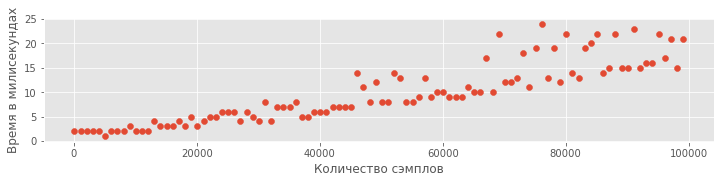

In [19]:
## Время выполнения алгоритма KMeans
%matplotlib inline
from time import time
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)
num_samles = np.arange(100,100000,1000)
time_samples = np.zeros(num_samles.shape)
t = 10
ind = 0
for n in num_samles:
    X, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model = Kmeans()
    times = np.zeros(t)
    for i in xrange(t):
        tic = time()
        model = model.fit(X)
        toc = time()
        times[i] = toc - tic    
    time_samples[ind] = times.min()
    ind += 1
fig = plt.figure()
ax = fig.add_subplot(211)
ax.scatter(num_samles,time_samples*1000)
ax.yaxis.set_label_position('left')
ax.set_ylabel(u'Время в милисекундах')
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(u'Количество сэмплов')


total centroids moves: 6.4961482361
total centroids moves: 0.0
total centroids moves: 6.4961482361
total centroids moves: 0.0
total centroids moves: 6.49183874275
total centroids moves: 0.0680697451536
total centroids moves: 0.0
total centroids moves: 6.4961482361
total centroids moves: 0.0
total centroids moves: 6.4961482361
total centroids moves: 0.0
total centroids moves: 6.4961482361
total centroids moves: 0.0
total centroids moves: 6.4888414687
total centroids moves: 0.0857649352652
total centroids moves: 0.0
total centroids moves: 6.4961482361
total centroids moves: 0.0
total centroids moves: 6.4961482361
total centroids moves: 0.0
total centroids moves: 6.4888414687
total centroids moves: 0.0857649352652
total centroids moves: 0.0
total centroids moves: 6.58752034183
total centroids moves: 0.00422555577628
total centroids moves: 6.58471165452
total centroids moves: 0.0127118931353
total centroids moves: 0.00198365963303
total centroids moves: 6.57590808622
total centroids moves:

total centroids moves: 6.56039718952
total centroids moves: 0.0928172504085
total centroids moves: 0.00246016333809
total centroids moves: 6.55958755475
total centroids moves: 0.0162812124225
total centroids moves: 0.000497451973917
total centroids moves: 6.53815934922
total centroids moves: 0.105646992474
total centroids moves: 0.00293744280737
total centroids moves: 6.53838719165
total centroids moves: 0.399255933536
total centroids moves: 0.0166783463019
total centroids moves: 0.00049001775128
total centroids moves: 6.9152641303
total centroids moves: 1.0816141438
total centroids moves: 0.315962369979
total centroids moves: 0.0109979512398
total centroids moves: 0.000248882198697
total centroids moves: 6.55759619698
total centroids moves: 0.0262991561581
total centroids moves: 0.000497451973917
total centroids moves: 6.5619305204
total centroids moves: 0.00147775973959
total centroids moves: 6.55985123704
total centroids moves: 0.00673479664904
total centroids moves: 6.4846185739
to

total centroids moves: 6.55785375347
total centroids moves: 0.0203243433456
total centroids moves: 0.00099899112331
total centroids moves: 6.56186143977
total centroids moves: 0.0578052802338
total centroids moves: 0.00135754260461
total centroids moves: 6.55985149652
total centroids moves: 0.00909809736183
total centroids moves: 6.56084270957
total centroids moves: 0.00363795360288
total centroids moves: 6.5604826539
total centroids moves: 0.00384750878674
total centroids moves: 6.56142404488
total centroids moves: 0.00441878384387
total centroids moves: 6.5620738999
total centroids moves: 0.0281428182718
total centroids moves: 0.000613070247547
total centroids moves: 6.55981012416
total centroids moves: 0.00968337221111
total centroids moves: 6.5627431246
total centroids moves: 0.00809721278117
total centroids moves: 6.08250380996
total centroids moves: 0.722528683632
total centroids moves: 1.24246909252
total centroids moves: 0.00912762772958
total centroids moves: 6.56201057973
tot

total centroids moves: 6.56237767332
total centroids moves: 0.00852869805677
total centroids moves: 6.5633619491
total centroids moves: 0.0374358373921
total centroids moves: 0.001146002685
total centroids moves: 6.56435635246
total centroids moves: 0.0116516323042
total centroids moves: 0.000493038144112
total centroids moves: 6.5645291686
total centroids moves: 0.0170494295651
total centroids moves: 0.00065576101854
total centroids moves: 6.52033041759
total centroids moves: 0.179157710579
total centroids moves: 0.00613918662583
total centroids moves: 6.54712559934
total centroids moves: 0.27146052501
total centroids moves: 0.00761203635212
total centroids moves: 6.56041967205
total centroids moves: 0.0196261564233
total centroids moves: 0.000824534414761
total centroids moves: 6.56350747205
total centroids moves: 0.00559650637418
total centroids moves: 6.56426675237
total centroids moves: 0.017236408864
total centroids moves: 0.000709237396496
total centroids moves: 6.56409531691
to

total centroids moves: 6.56387148081
total centroids moves: 0.0128463666612
total centroids moves: 0.000325687440265
total centroids moves: 6.56422032653
total centroids moves: 0.00381728935565
total centroids moves: 6.55838637942
total centroids moves: 0.0418273877396
total centroids moves: 0.000921775885849
total centroids moves: 6.56251716373
total centroids moves: 0.0197630047892
total centroids moves: 0.000553430136139
total centroids moves: 6.5655648574
total centroids moves: 0.00449036670522
total centroids moves: 6.56638931333
total centroids moves: 0.0139013697881
total centroids moves: 0.000491390132276
total centroids moves: 6.56708087321
total centroids moves: 0.0270675592747
total centroids moves: 0.000614524599598
total centroids moves: 6.56653277015
total centroids moves: 0.00602501591811
total centroids moves: 6.5670446788
total centroids moves: 0.0296592066074
total centroids moves: 0.000798551014
total centroids moves: 6.49125542278
total centroids moves: 0.3095267940

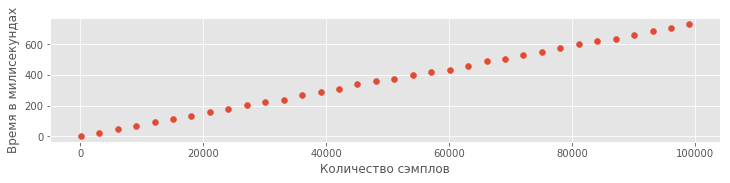

In [20]:
## Время выполнения алгоритма KMeans++
%matplotlib inline
from time import time
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)
num_samles = np.arange(100,100000,3000)
time_samples = np.zeros(num_samles.shape)
t = 10
ind = 0
for n in num_samles:
    X, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model = Kmeans(init='k-means')
    times = np.zeros(t)
    for i in xrange(t):
        tic = time()
        model = model.fit(X)
        toc = time()
        times[i] = toc - tic    
    time_samples[ind] = times.min()
    ind += 1
fig = plt.figure()
ax = fig.add_subplot(211)
ax.scatter(num_samles,time_samples*1000)
ax.yaxis.set_label_position('left')
ax.set_ylabel(u'Время в милисекундах')
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(u'Количество сэмплов')

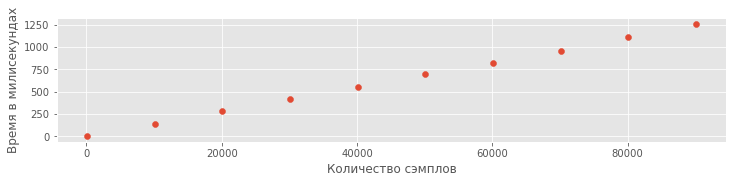

In [48]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
%matplotlib inline
from time import time
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)
num_samles = np.arange(100,100000,10000)
time_samples = np.zeros(num_samles.shape)
t = 10
ind = 0
for n in num_samles:
    X, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model_mini_batch = MiniBatchKMeans()
    model_mini_batch.init_mini_batch(X,b=10)
    times = np.zeros(t)
    for i in xrange(t):
        tic = time()
        model_mini_batch = model_mini_batch.miniBatchFit(X)
        toc = time()
        times[i] = toc - tic    
    time_samples[ind] = times.min()
    ind += 1
fig = plt.figure()
ax = fig.add_subplot(211)
ax.scatter(num_samles,time_samples*1000)
ax.yaxis.set_label_position('left')
ax.set_ylabel(u'Время в милисекундах')
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(u'Количество сэмплов')


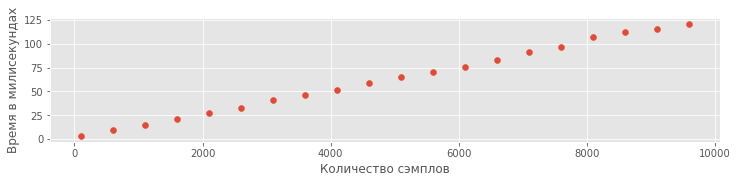

In [49]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans
%matplotlib inline
from time import time
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)
num_samles = np.arange(100,10000,500)
time_samples = np.zeros(num_samles.shape)
t = 10
ind = 0
for n in num_samles:
    X, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model_mini_batch = MiniBatchKMeans(init='k-means')
    model_mini_batch.init_mini_batch(X,b=10)
    times = np.zeros(t)
    for i in xrange(t):
        tic = time()
        model_mini_batch = model_mini_batch.miniBatchFit(X)
        toc = time()
        times[i] = toc - tic    
    time_samples[ind] = times.min()
    ind += 1
fig = plt.figure()
ax = fig.add_subplot(211)
ax.scatter(num_samles,time_samples*1000)
ax.yaxis.set_label_position('left')
ax.set_ylabel(u'Время в милисекундах')
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(u'Количество сэмплов')

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [50]:
## KMeans
import pandas as pd
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns = df_sns.drop(['gradyear', 'gender','age','friends'],axis=1)
X = df_sns.iloc[:,1:].values
X = (X - X.mean(axis=0)) / X.std(axis=0)
model = Kmeans(k=9, max_iter=1000,eps=0.001)
model.fit(X)
df_sns.loc[:,'labels'] = model.predict(X)
print df_sns.groupby('labels').agg('mean').transpose()

total centroids moves: 3.33054865069
total centroids moves: 1.05209783874
total centroids moves: 0.804874909146
total centroids moves: 0.483278120255
total centroids moves: 0.328820674696
total centroids moves: 0.258055144521
total centroids moves: 0.212569418568
total centroids moves: 0.200396727462
total centroids moves: 0.213267697635
total centroids moves: 0.257897108988
total centroids moves: 0.219853540446
total centroids moves: 0.145397205679
total centroids moves: 0.111400543768
total centroids moves: 0.108338856024
total centroids moves: 0.101716756511
total centroids moves: 0.0629793907742
total centroids moves: 0.0413727479008
total centroids moves: 0.03293379489
total centroids moves: 0.0308193682622
total centroids moves: 0.0276224902887
total centroids moves: 0.0256916953595
total centroids moves: 0.0291297549656
total centroids moves: 0.0269427436537
total centroids moves: 0.0314580471622
total centroids moves: 0.0282693648235
total centroids moves: 0.0160529316385
total

In [51]:
## KMeans++
import pandas as pd
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns = df_sns.drop(['gradyear', 'gender','age','friends'],axis=1)
X = df_sns.iloc[:,1:].values
X = (X - X.mean(axis=0)) / X.std(axis=0)
modelplus = Kmeans(k=9, max_iter=1000,init='k-means',eps=0.01)
modelplus.fit(X)

df_sns.loc[:,'labels'] = modelplus.predict(X)
print df_sns.groupby('labels').agg('mean').transpose()

total centroids moves: 51.7466653889
total centroids moves: 1.27752689371
total centroids moves: 0.869458556978
total centroids moves: 0.448572718032
total centroids moves: 0.304774220844
total centroids moves: 0.178158919046
total centroids moves: 0.102103154215
total centroids moves: 0.0779310303233
total centroids moves: 0.0641838883258
total centroids moves: 0.0611408567769
total centroids moves: 0.200818797471
total centroids moves: 0.121235859057
total centroids moves: 0.108627501863
total centroids moves: 0.128774268167
total centroids moves: 0.186422036517
total centroids moves: 0.148325716683
total centroids moves: 0.232328100814
total centroids moves: 0.134629678712
total centroids moves: 0.0877229188003
total centroids moves: 0.0953562872634
total centroids moves: 0.11028467248
total centroids moves: 0.0631224981756
total centroids moves: 0.0757566938389
total centroids moves: 0.0668809942136
total centroids moves: 0.0695309068238
total centroids moves: 0.0523005055325
total

In [52]:
## KMeans с MiniBatchKMeans
import pandas as pd
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns = df_sns.drop(['gradyear', 'gender','age','friends'],axis=1)
X = df_sns.iloc[:,1:].values
X = (X - X.mean(axis=0)) / X.std(axis=0)
model_mini_batch = MiniBatchKMeans(k=9,max_iter=1000,eps=0.1)
model_mini_batch.init_mini_batch(X,b=100)
model_mini_batch.miniBatchFit(X)
df_sns.loc[:,'labels'] = model_mini_batch.predict(X)
print df_sns.groupby('labels').agg('mean').transpose()

labels               0         1         2      3         4         5  \
basketball    0.278669  0.482570  0.345287    0.0  0.117982  0.228965   
football      0.372494  0.839563  0.255779    1.0  0.009649  0.441220   
soccer        0.062951  0.205796  0.173088    0.0  0.011111  0.346233   
softball      0.185245  0.624528  0.316242    0.0  0.091082  0.097918   
volleyball    0.022053  0.253675  0.081209    0.0  0.098246  0.045441   
swimming      0.118685  0.149517  0.562833    0.5  0.065789  0.032542   
cheerleading  0.363272  0.199076  0.054535    0.0  0.019006  0.082087   
baseball      0.039695  0.165477  0.047718    0.0  0.004532  0.014952   
tennis        0.027666  0.021000  0.037344    0.0  0.002632  0.026678   
sports        0.029270  0.294414  0.696503    0.0  0.004094  0.034301   
cute          0.876905  0.351533  0.246592    0.5  0.020029  0.413662   
sex           0.172013  0.588408  0.336396   68.0  0.106433  0.102609   
sexy          0.107458  0.140277  0.472436    0.5  

In [53]:
## KMeans++ с MiniBatchKMeans
import pandas as pd
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns = df_sns.drop(['gradyear', 'gender','age','friends'],axis=1)
X = df_sns.iloc[:,1:].values
X = (X - X.mean(axis=0)) / X.std(axis=0)
model_mini_batch = MiniBatchKMeans(k=9,max_iter=1000,init='k-means',eps=0.1)
model_mini_batch.init_mini_batch(X,b=100)
model_mini_batch.miniBatchFit(X)
df_sns.loc[:,'labels'] = model_mini_batch.predict(X)
print df_sns.groupby('labels').agg('mean').transpose()

labels               0      1          2      3     4     5     6          7  \
basketball    0.267141    0.0   0.166667    0.0   0.0   0.0   1.0   1.500000   
football      0.251686    2.0   0.000000    0.0   0.2   0.0   0.0   3.166667   
soccer        0.222211    0.0   0.500000    0.0   0.0   0.0   0.0   1.333333   
softball      0.161159    0.0   0.000000    0.0   0.0   0.0   0.0   0.666667   
volleyball    0.143134    0.0   0.000000    0.0   0.0   0.0   0.0   0.500000   
swimming      0.134021    1.0   0.000000    0.0   0.0   0.0   0.0   0.500000   
cheerleading  0.106182    0.0   0.000000    0.0   0.0   0.0   0.0   2.166667   
baseball      0.104680    0.0   0.333333    0.0   0.0   0.0   0.0   1.166667   
tennis        0.086955    0.0   0.166667    0.0   0.0   0.0   0.0   0.833333   
sports        0.139061    0.0   0.000000    0.0   0.4   0.0   0.0   4.333333   
cute          0.321951    1.0   0.166667    0.0   0.4   0.0   0.5   3.666667   
sex           0.202250   22.0   0.166667

In [ ]:
## Вывод
''''
1) Из п. 4 стало понятно, что алгоритм K-means miniBatch работал быстрее всего (видно после замеров времени выполнения)
Это связано с тем, что на каждой итерации в вызове 
C = np.array([np.argmin([np.dot(x - cent, x - cent) for cent in self.centroids]) for x in X])
в качестве Х была небольшая подвыборка. Опытным путем было установлено, что этот и тоько этот вызов(кроме инициализации, а
о ней ниже) влиял на скорость выполнение алгоритма.
2) По описаию алгоритма miniBatch видно, что он никак не влияет на качество результата. Только на скорость.
3) Сравнение k-means и k-means++. С точки зрения времени работы, ++ выполнялся дольше из-за инициализации, т.к в обычном
k-means мы тупо рандомим один вектор и все. Что касается качества, то из распечаток выше видно, что с ++ деление происходило
немного по-другому. Появились кластеры, в которых очень много средних значений = 0. Это связано с "более правильной и 
логичной" инициализации начальных центроид. В результате были получены кластеры, в которых достаточно мало объектов,
однако они все практически идентичны. Достоинство это или недостаток - зависит от поставленной задачи. Если требуется выделить
"сильно отличающиеся" ото всех остальных объекты (как например объект, у которого поле Blonde много больше среднего остальных. 
Опять же это видно в распечатках выше), то данная модификация уместна. Так же было установлено (в 4 пункте задания), что при
многократном запуске обычного k-means, могли получатся разные результаты, порой не совсем верные. Это связано с рандомной
инициализацией начальных центроид.
4) Вывод. k-means++ работает более стабильно и предсказуемо, не давая в общем случае прирост скорости,
k-means miniBatch дает значительный (зависит от размера подвыборки) прирост скорости, однако не дает никакого,
в общем случае, улучшения результата.
P.S на выполнение алгоритмов с реальными данными порой уходило около минуты.  В среднем 30-40 секунд. Программы не зависают,
надо просто немного подождать)
''''